<a href="https://colab.research.google.com/github/mdruesch98/ptmma25-data-science-for-business-II-team-assignment/blob/main/InfluencerNet_SubmissionTemplate_MD_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Computer Vision & Image Mining**

Prof. Dr. Jochen Hartmann (TUM)

### **Individual Case Study: "InfluencerNet"**

In [ ]:
YOUR_NAME = 'Maximilian Drüschler'

Please use this template for your submission. It should include all analyses (as documented Python code) and answers to the case study. Please refer to the course syllabus for detailed submission instructions and the submission deadline.

__Important:__ Please keep all your answers short and crisp. <br>

The submission template's structure is based on Appendix B: Machine Learning Project Checklist in [Géron (2019)](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).


### 1. Frame the Problem

The goal of the assignment is to train a machine learning model to classify if a picture has a logo in it or not. Since the data (pictures) we train the model with are labeled, we are talking about a supervised learning problem.

We could train a "standard", fully connected neural network for that purpose but since we are working with high-dimensional image data this would result in a massive number of parameters and therefore would not be efficient.

That is why a Convulational Neural Network (ConvNet) is a better option here. With built-in convulational layers, a ConvNet reduces the amount of parameters by applying "kernels" (simplified you could call them filters) which extract only the relevant features of an image.

Possible ConvNet architectures to choose from are: VGG-16, EfficientNet, AlexNet, ResNet etc..

### 2. Get the Data

In [5]:
# Loading necessary packages
import numpy as np
import tensorflow as tf
from keras import datasets, layers, models, optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os, shutil
import random
import cv2
from PIL import Image
from skimage import io, color, transform

In [1]:
# Connect to drive for access on the image data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Defining paths to base directories, where the images are currently stored
base_dir = '/content/drive/MyDrive/InfluencerNet/InfluencerNet_Images'
base_LogoNo_dir = '/content/drive/MyDrive/InfluencerNet/InfluencerNet_Images/LogoNo_Tiny'
base_LogoYes_dir = '/content/drive/MyDrive/InfluencerNet/InfluencerNet_Images/LogoYes_Tiny'

In [6]:
# Creating paths for training, validation and test data
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

train_LogoYes_dir = os.path.join(train_dir, 'LogoYes')
os.makedirs(train_LogoYes_dir, exist_ok=True)

train_LogoNo_dir = os.path.join(train_dir, 'LogoNo')
os.makedirs(train_LogoNo_dir, exist_ok=True)

validation_LogoYes_dir = os.path.join(validation_dir, 'LogoYes')
os.makedirs(validation_LogoYes_dir, exist_ok=True)

validation_LogoNo_dir = os.path.join(validation_dir, 'LogoNo')
os.makedirs(validation_LogoNo_dir, exist_ok=True)

test_LogoYes_dir = os.path.join(test_dir, 'LogoYes')
os.makedirs(test_LogoYes_dir, exist_ok=True)

test_LogoNo_dir = os.path.join(test_dir, 'LogoNo')
os.makedirs(test_LogoNo_dir, exist_ok=True)

### 3. Explore the Data

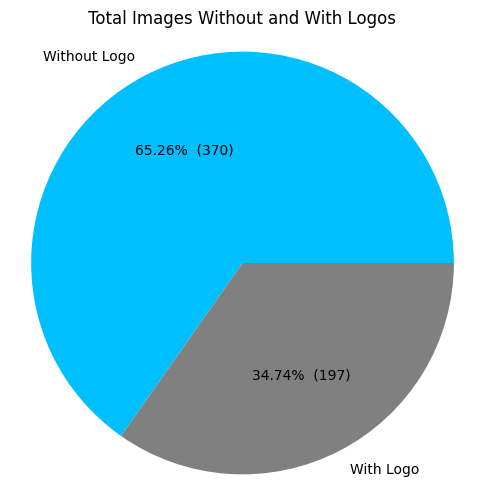

In [8]:
# Get the total number of images for each class
total_without_logo = len(os.listdir(base_LogoNo_dir))
total_with_logo = len(os.listdir(base_LogoYes_dir))

# Create a pie chart
labels = ['Without Logo', 'With Logo']
sizes = [total_without_logo, total_with_logo]
colors = ['deepskyblue', 'grey']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(sizes)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct=make_autopct(sizes))
plt.title('Total Images Without and With Logos')
plt.axis('equal')

plt.show()

We see, that the number of images in the dataset is pretty small with just 567 images in total. That is why we will augment the pictures (mirroring and rotation) in the data preparation step, so that we create more pictures to train the models on.

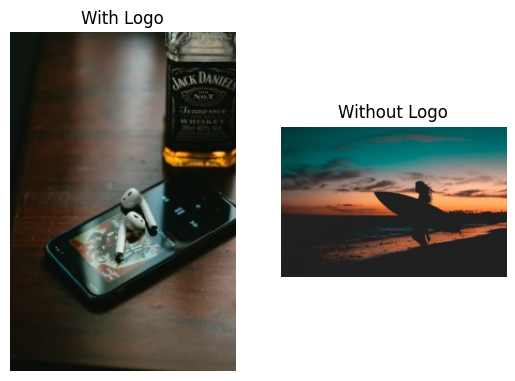

In [11]:
# For data exploration we look at one of the pictures in each directory to get a better feeling how the images are structured
# Set the file paths
base_LogoYes_file = os.path.join(base_LogoYes_dir, os.listdir(base_LogoYes_dir)[1])
base_LogoNo_file = os.path.join(base_LogoNo_dir, os.listdir(base_LogoNo_dir)[2])

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=1, ncols=2)

# Plot the images
axs[0].imshow(plt.imread(base_LogoYes_file))
axs[0].set_title('With Logo')
axs[0].axis('off')

axs[1].imshow(plt.imread(base_LogoNo_file))
axs[1].set_title('Without Logo')
axs[1].axis('off')

# Show the plot
plt.show()

From the example pictures we now know that we are training our models on real-world images.

Furthermore, we see that they come in different formats. As a result we need to rescale them so that our models can process them better.

### 4. Prepare the Data

The dataset presents some challenges:
The pictures seem to be in different formats. In order to train the model properly, we need to rescale them.

Our dataset is pretty small. Due to the small size our model might overfit the training data and therefore perform poor on the test data because of generalization error.

In order to fix this we can:
  - augment the pictures to add images with at least some variation
  - add a dropout layer into the architecture of the convnet
  (we will do that later when building the convnet)
  - add image data from other (publicly available) datasets

#### 4.1 Augmenting the data to increase the size of the dataset

In [12]:
# Because of the small dataset, augmenting the data will yield better results --> creates more training data

# Function to mirror images horizontally and vertically
def mirror_images(image_dir, output_dir):
    for filename in os.listdir(image_dir):
        img = cv2.imread(os.path.join(image_dir, filename))
        img_flip_horizontal = cv2.flip(img, 1)
        img_flip_vertical = cv2.flip(img, 0)
        cv2.imwrite(os.path.join(output_dir, f"mirrored_horizontal_{filename}"), img_flip_horizontal)
        cv2.imwrite(os.path.join(output_dir, f"mirrored_vertical_{filename}"), img_flip_vertical)

# Function to rotate images by 90 degrees
def rotate_images(image_dir, output_dir):
    for filename in os.listdir(image_dir):
        img = io.imread(os.path.join(image_dir, filename))
        img_rotated = transform.rotate(img, angle=90, resize=False, preserve_range=True).astype(np.uint8)
        io.imsave(os.path.join(output_dir, f"rotated_90_{filename}"), img_rotated)

# Creating output directories for augmented images
augmented_LogoYes_dir = '/content/InfluencerNet/InfluencerNet_Images/Augmented_LogoYes_Tiny'
os.makedirs(augmented_LogoYes_dir, exist_ok=True)

augmented_LogoNo_dir = '/content/InfluencerNet/InfluencerNet_Images/Augmented_LogoNo_Tiny'
os.makedirs(augmented_LogoNo_dir, exist_ok=True)

# Apply defined functions on data
mirror_images(base_LogoNo_dir, augmented_LogoNo_dir)
rotate_images(base_LogoNo_dir, augmented_LogoNo_dir)

mirror_images(base_LogoYes_dir, augmented_LogoYes_dir)
rotate_images(base_LogoYes_dir, augmented_LogoYes_dir)

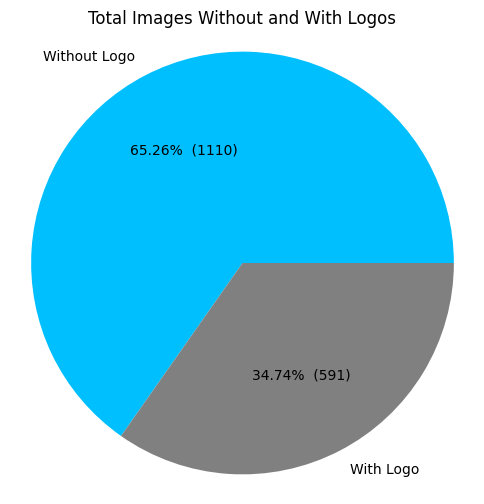

In [13]:
# Checking if the functions worked as intended by creating an additional pie chart with new total numbers
# Get the total number of images for each class
augmented_total_without_logo = len(os.listdir(augmented_LogoNo_dir))
augmented_total_with_logo = len(os.listdir(augmented_LogoYes_dir))

# Create a pie chart
labels = ['Without Logo', 'With Logo']
sizes = [augmented_total_without_logo, augmented_total_with_logo]
colors = ['deepskyblue', 'grey']

def make_autopct(values):
    def my_autopct(pct):
        total = sum(sizes)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct=make_autopct(sizes))
plt.title('Total Images Without and With Logos')
plt.axis('equal')

plt.show()

We now see that we have trippled the size of the dataset (added 1,134 images)  by applying two forms of augmentation (mirroring and rotation)


Since I only found one dataset only which has roughly the same type of real-world logo images (FlickrLogo), and did not get access to it, I will not add additional image data from other datasets for this assignment.

#### 4.2 Splitting the data into training, validation and test set

In [14]:
# Splitting the data into training, validation and test sets and storing it in the respective directory
# training (60-80%), validation (10-20%) and test (10-20%)

# Set the ratio of images to use for training, validation, and test data
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

# Calculate the number of images to use for each dataset (LogoNo)
num_train_LogoNo = int(len(os.listdir(augmented_LogoNo_dir)) * train_ratio)
num_val_LogoNo = int(len(os.listdir(augmented_LogoNo_dir)) * val_ratio)
num_test_LogoNo = len(os.listdir(augmented_LogoNo_dir)) - num_train_LogoNo - num_val_LogoNo


# Split the images into training, validation, and test sets (LogoNo)
for i, filename in enumerate(os.listdir(augmented_LogoNo_dir)):
    if i < num_train_LogoNo:
        shutil.copy(augmented_LogoNo_dir + '/' + filename, train_LogoNo_dir + '/' + filename)
    elif i < num_train_LogoNo + num_val_LogoNo:
        shutil.copy(augmented_LogoNo_dir + '/' + filename, validation_LogoNo_dir + '/' + filename)
    else:
        shutil.copy(augmented_LogoNo_dir + '/' + filename, test_LogoNo_dir + '/' + filename)

# Calculate the number of images to use for each dataset (LogoYes)
num_train_LogoYes = int(len(os.listdir(augmented_LogoYes_dir)) * train_ratio)
num_val_LogoYes = int(len(os.listdir(augmented_LogoYes_dir)) * val_ratio)
num_test_LogoYes = len(os.listdir(augmented_LogoYes_dir)) - num_train_LogoYes - num_val_LogoYes


# Split the images into training, validation, and test sets (LogoYes)
for i, filename in enumerate(os.listdir(augmented_LogoYes_dir)):
    if i < num_train_LogoYes:
        shutil.copy(augmented_LogoYes_dir + '/' + filename, train_LogoYes_dir + '/' + filename)
    elif i < num_train_LogoYes + num_val_LogoYes:
        shutil.copy(augmented_LogoYes_dir + '/' + filename, validation_LogoYes_dir + '/' + filename)
    else:
        shutil.copy(augmented_LogoYes_dir + '/' + filename, test_LogoYes_dir + '/' + filename)

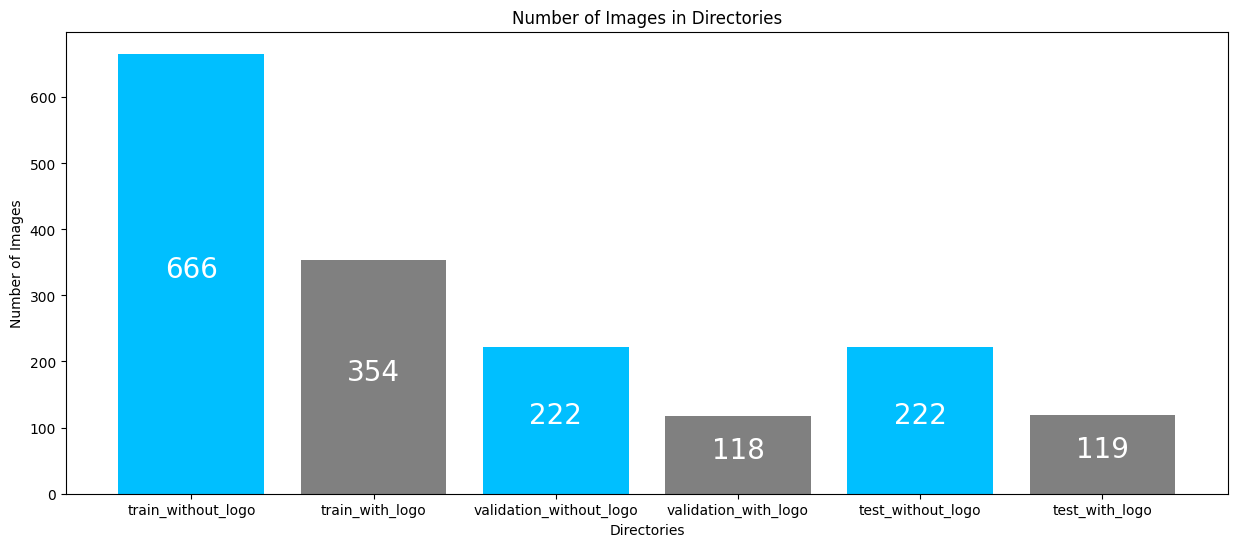

In [15]:
# Checking if it worked --> Counting how many pictures are in each directory.

# Get the number of images in each directory
train_without_logo = len(os.listdir(train_LogoNo_dir))
train_with_logo = len(os.listdir(train_LogoYes_dir))
validation_without_logo = len(os.listdir(validation_LogoNo_dir))
validation_with_logo = len(os.listdir(validation_LogoYes_dir))
test_without_logo = len(os.listdir(test_LogoNo_dir))
test_with_logo = len(os.listdir(test_LogoYes_dir))

# Create a list of categories and their corresponding values
categories_bar = ['train_without_logo', 'train_with_logo', 'validation_without_logo', 'validation_with_logo', 'test_without_logo', 'test_with_logo']
values_bar = [train_without_logo, train_with_logo, validation_without_logo, validation_with_logo, test_without_logo, test_with_logo]
colors_bar = ['deepskyblue', 'grey', 'deepskyblue', 'grey', 'deepskyblue', 'grey']

# Create a bar plot
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

# Add bars
bars = ax.bar(categories_bar, values_bar, color=colors_bar)

# Add text on each bar
for i, bar in enumerate(bars):
    height = bar.get_height() / 2
    ax.text(bar.get_x() + bar.get_width() / 2, height - 5, values_bar[i], ha='center', color='white', fontsize=20)

plt.title('Number of Images in Directories')
plt.xlabel('Directories')
plt.ylabel('Number of Images')
plt.show()

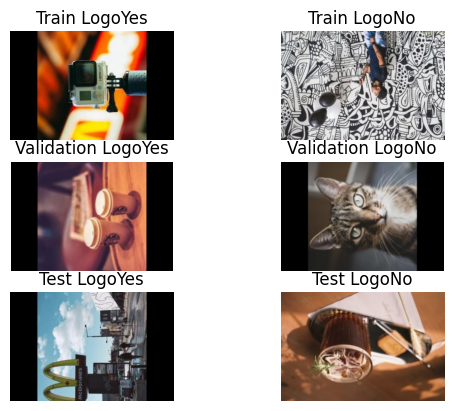

In [17]:
# Exploring the pictures further while checking if they're in the correct folder (by picking 1 sample out of each directory)

# Set the file paths
train_LogoYes_file = os.path.join(train_LogoYes_dir, os.listdir(train_LogoYes_dir)[1])
train_LogoNo_file = os.path.join(train_LogoNo_dir, os.listdir(train_LogoNo_dir)[2])
validation_LogoYes_file = os.path.join(validation_LogoYes_dir, os.listdir(validation_LogoYes_dir)[3])
validation_LogoNo_file = os.path.join(validation_LogoNo_dir, os.listdir(validation_LogoNo_dir)[4])
test_LogoYes_file = os.path.join(test_LogoYes_dir, os.listdir(test_LogoYes_dir)[5])
test_LogoNo_file = os.path.join(test_LogoNo_dir, os.listdir(test_LogoNo_dir)[6])

# Create a figure and a set of subplots
fig, axs = plt.subplots(nrows=3, ncols=2)

# Plot the images
axs[0, 0].imshow(plt.imread(train_LogoYes_file))
axs[0, 0].set_title('Train LogoYes')
axs[0, 0].axis('off')

axs[0, 1].imshow(plt.imread(train_LogoNo_file))
axs[0, 1].set_title('Train LogoNo')
axs[0, 1].axis('off')

axs[1, 0].imshow(plt.imread(validation_LogoYes_file))
axs[1, 0].set_title('Validation LogoYes')
axs[1, 0].axis('off')

axs[1, 1].imshow(plt.imread(validation_LogoNo_file))
axs[1, 1].set_title('Validation LogoNo')
axs[1, 1].axis('off')

axs[2, 0].imshow(plt.imread(test_LogoYes_file))
axs[2, 0].set_title('Test LogoYes')
axs[2, 0].axis('off')

axs[2, 1].imshow(plt.imread(test_LogoNo_file))
axs[2, 1].set_title('Test LogoNo')
axs[2, 1].axis('off')

# Show the plot
plt.show()

#### 4.3 Setting up generators for rescaling the images and feeding them to the models

In [19]:
# Setting up the generators for rescaling and feeding the data to the models in training and validation phase

train_datagen = ImageDataGenerator(rescale=1./255)


val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 1020 images belonging to 2 classes.
Found 340 images belonging to 2 classes.


### 5. Shortlist Promising Models

#### 5.1 Building and Training own ConvNet Architecture from Scratch

##### 5.1.1 Starting with a simple ConvNet Architecture

In [20]:
# Self-made ConvNet

# Defining ConvNet structure
own_model = models.Sequential()
own_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
own_model.add(layers.MaxPooling2D((2, 2)))
own_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
own_model.add(layers.MaxPooling2D((2, 2)))
own_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
own_model.add(layers.MaxPooling2D((2, 2)))
own_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
own_model.add(layers.MaxPooling2D((2, 2)))
own_model.add(layers.Flatten())
own_model.add(layers.Dense(512, activation='relu'))
own_model.add(layers.Dense(1, activation='sigmoid'))

own_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc']
                  )


own_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [21]:
# Training the model
history_own = own_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15
)

Epoch 1/20
50/50 [==============================] - 13s 122ms/step - loss: 0.6611 - acc: 0.6420 - val_loss: 0.6495 - val_acc: 0.6500
Epoch 2/20
50/50 [==============================] - 5s 103ms/step - loss: 0.6467 - acc: 0.6590 - val_loss: 0.6531 - val_acc: 0.6433
Epoch 3/20
50/50 [==============================] - 7s 138ms/step - loss: 0.6428 - acc: 0.6560 - val_loss: 0.6489 - val_acc: 0.6400
Epoch 4/20
50/50 [==============================] - 5s 105ms/step - loss: 0.6384 - acc: 0.6580 - val_loss: 0.6384 - val_acc: 0.6567
Epoch 5/20
50/50 [==============================] - 7s 137ms/step - loss: 0.6277 - acc: 0.6640 - val_loss: 0.6802 - val_acc: 0.6500
Epoch 6/20
50/50 [==============================] - 5s 107ms/step - loss: 0.6238 - acc: 0.6690 - val_loss: 0.6941 - val_acc: 0.6500
Epoch 7/20
50/50 [==============================] - 7s 133ms/step - loss: 0.6081 - acc: 0.6810 - val_loss: 0.6292 - val_acc: 0.6467
Epoch 8/20
50/50 [==============================] - 5s 106ms/step - loss: 0

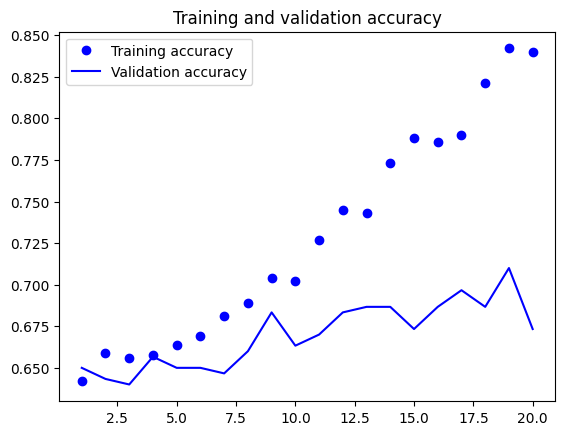

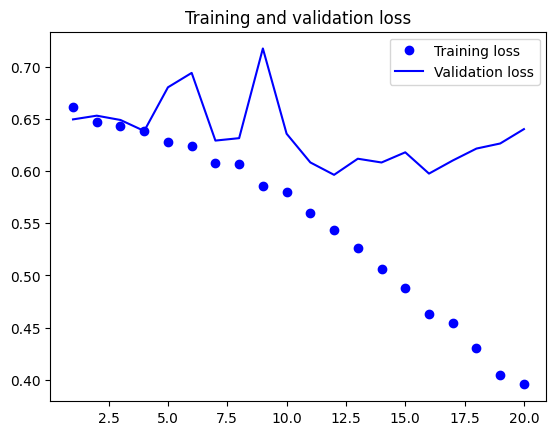

In [23]:
# Plotting Training and Validation Accuracy/Loss
acc_own = history_own.history['acc']
val_acc_own = history_own.history['val_acc']
loss_own = history_own.history['loss']
val_loss_own = history_own.history['val_loss']

epochs = range(1, len(acc_own) + 1)

plt.plot(epochs, acc_own, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_own, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_own, 'bo', label='Training loss')
plt.plot(epochs, val_loss_own, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The results for the first model shown in the figures above are ok for the first shot. However, the charts show signs of overfitting.

While the training accuracy increases with each epoch and the training loss increases respectively, the validation loss and accuracy stay constant at 60-70% each.

That's why in the next step, I will try to again add some augmentations to the data so that there is a bit more variation in the training set.

#### 5.1.2 Adding Data Augmentation to the training data generator

One measure to prevent overfitting is adding data augmentation parameters to the training data generator (e.g. shifting operations).

Since we already augmented the data in a previous step and the real-world images contain logos which are pretty small and some of them on the edge of the image, this could also turn out to be bad for our model training, since the shifting could push some logos out of the training image while still being labeled as a "With logo" picture -> resulting in misclassification and a poor performance.

However, it is worth a try.

In [24]:
# Setting up a new Data Generator with Augmentation parameters
augmented_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.2,
    horizontal_flip=True
)

augmented_generator = augmented_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

Found 1020 images belonging to 2 classes.


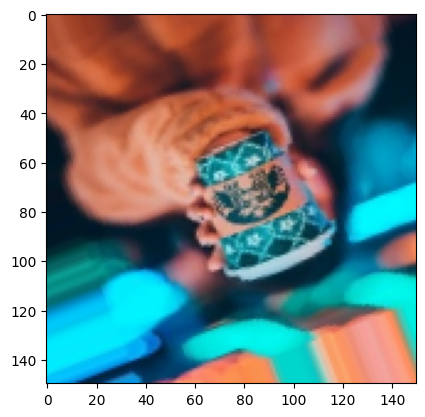

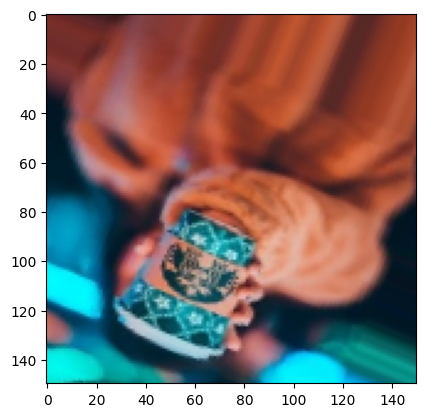

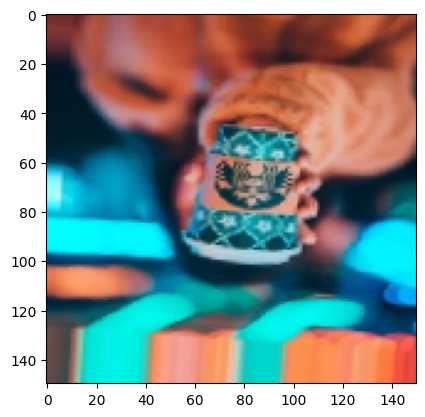

Yes, the augmentation works -> as you can see the result of the augmentation are subtle variations in the training images.


In [27]:
# Checking if the augmentation works:
example_filenames = [os.path.join(train_LogoYes_dir, fname) for
                    fname in os.listdir(train_LogoYes_dir)
                    ]

example1_img_path = example_filenames[2]

img = image.load_img(example1_img_path, target_size=(150,150))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in augmented_datagen.flow(x, batch_size=1) :
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 3 == 0 :
    break


plt.show()
print('Yes, the augmentation works -> as you can see the result of the augmentation are subtle variations in the training images.')

In [28]:
# Setting up a new model with same architecture for training with augmented images


# Defining ConvNet structure incl. Dropout layer as explained above
aug_own_model = models.Sequential()
aug_own_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
aug_own_model.add(layers.MaxPooling2D((2, 2)))
aug_own_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
aug_own_model.add(layers.MaxPooling2D((2, 2)))
aug_own_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_own_model.add(layers.MaxPooling2D((2, 2)))
aug_own_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
aug_own_model.add(layers.MaxPooling2D((2, 2)))
aug_own_model.add(layers.Flatten())
aug_own_model.add(layers.Dense(512, activation='relu'))
aug_own_model.add(layers.Dense(1, activation='sigmoid'))

aug_own_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc']
                  )

In [29]:
# Train the new model
# Training the model using the data augmentation generators defined earlier
history_aug_own = aug_own_model.fit(
    augmented_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15
)

Epoch 1/20
50/50 [==============================] - 13s 238ms/step - loss: 0.6564 - acc: 0.6570 - val_loss: 0.6628 - val_acc: 0.6400
Epoch 2/20
50/50 [==============================] - 11s 219ms/step - loss: 0.6532 - acc: 0.6540 - val_loss: 0.6422 - val_acc: 0.6667
Epoch 3/20
50/50 [==============================] - 12s 249ms/step - loss: 0.6496 - acc: 0.6530 - val_loss: 0.6392 - val_acc: 0.6533
Epoch 4/20
50/50 [==============================] - 15s 300ms/step - loss: 0.6464 - acc: 0.6570 - val_loss: 0.6595 - val_acc: 0.6700
Epoch 5/20
50/50 [==============================] - 13s 256ms/step - loss: 0.6468 - acc: 0.6570 - val_loss: 0.6545 - val_acc: 0.6400
Epoch 6/20
50/50 [==============================] - 15s 295ms/step - loss: 0.6456 - acc: 0.6510 - val_loss: 0.6578 - val_acc: 0.6600
Epoch 7/20
50/50 [==============================] - 11s 220ms/step - loss: 0.6397 - acc: 0.6570 - val_loss: 0.6389 - val_acc: 0.6433
Epoch 8/20
50/50 [==============================] - 11s 222ms/step - 

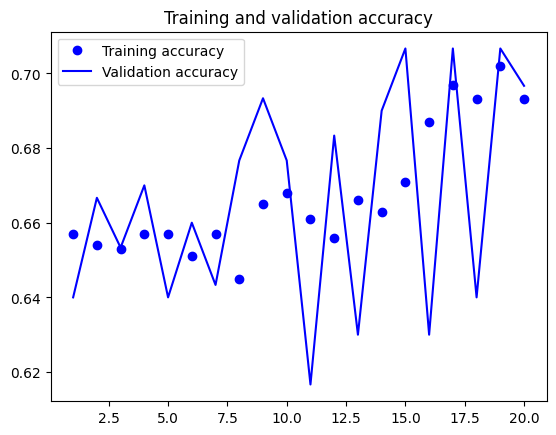

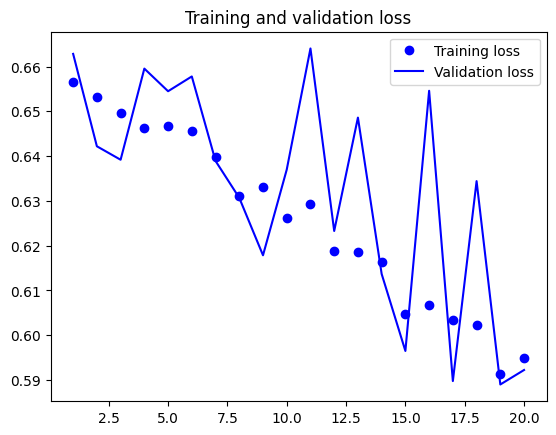

In [30]:
# Printing performance curves
acc_aug_own = history_aug_own.history['acc']
val_acc_aug_own = history_aug_own.history['val_acc']
loss_aug_own = history_aug_own.history['loss']
val_loss_aug_own = history_aug_own.history['val_loss']


# Plotting Training and Validation Accuracy/Loss
epochs = range(1, len(acc_aug_own) + 1)

plt.plot(epochs, acc_aug_own, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_aug_own, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_aug_own, 'bo', label='Training loss')
plt.plot(epochs, val_loss_aug_own, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Good news is, that now the signs of overfitting are gone. Training and Validation loss and accuracy behave roughly the same.

Bad news is, that both accuracies reached their maximum at approx. 70 % which is worse than the previous model.

The reason for that could be, as already discussed above, that the rotation and shift pushed some logos of the "LogoYes" images out of the image while still being labeled as "with logo" because the logos on the picture are relatively small and some of them are on the edge of the images. If this was true, the result would be that there are misclassified images in the training data resulting in false classification and a lower accuracy.

With the following code section, I will try to prove my argumentation.

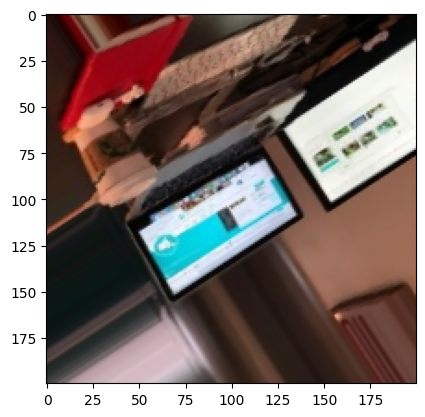

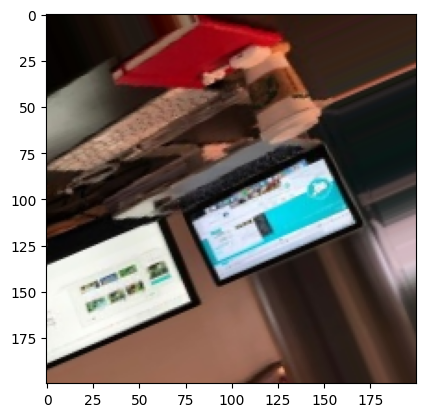

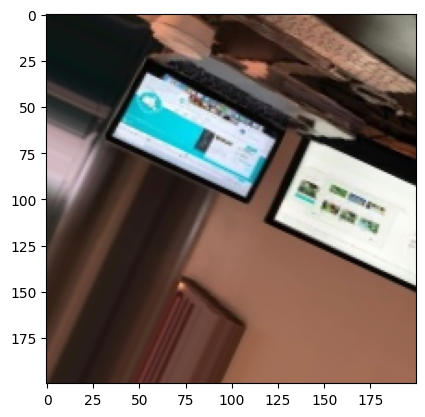

In [34]:
# Proving that with the new augmentation some logos are pushed out of the image resulting in misclassification and a lower accuracy.
example2_img_path = example_filenames[17]

img = image.load_img(example2_img_path, target_size=(200,200))

x = image.img_to_array(img)

x = x.reshape((1,) + x.shape)

i = 0
for batch in augmented_datagen.flow(x, batch_size=1) :
  plt.figure(i)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 3 == 0 :
    break


plt.show()

As expected, the third picture of the above series shows that some logos (in this case on the white coffee cup) are pushed out of the image by the augmentation. This is why I will stop using the augmentation from above.

Instead I will try to add a Dropout layer to the architecture of the convnet. This should also help to reduce the generalization error because a dropout layer randomly excludes neurons during training so that the convnet learns a more stable representation of the data without focusing too much on the training data.

##### 5.1.3 Adding a Dropout layer to my self-designed model to prevent overfitting

In [47]:
# Convnet with Dropout layer as explained
dropout_model = models.Sequential()
dropout_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150,150,3)))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
dropout_model.add(layers.MaxPooling2D((2, 2)))
dropout_model.add(layers.Flatten())
dropout_model.add(layers.Dropout(0.3))
dropout_model.add(layers.Dense(512, activation='relu'))
dropout_model.add(layers.Dense(1, activation='sigmoid'))

dropout_model.compile(loss='binary_crossentropy',
                  optimizer=optimizers.RMSprop(learning_rate=1e-4),
                  metrics=['acc']
                  )


dropout_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_26 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 17, 17, 128)      

In [48]:
# Training dropout model
history_dropout = dropout_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15
)

Epoch 1/20
50/50 [==============================] - 7s 108ms/step - loss: 0.6613 - acc: 0.6500 - val_loss: 0.6464 - val_acc: 0.6533
Epoch 2/20
50/50 [==============================] - 7s 139ms/step - loss: 0.6484 - acc: 0.6550 - val_loss: 0.6380 - val_acc: 0.6767
Epoch 3/20
50/50 [==============================] - 5s 105ms/step - loss: 0.6455 - acc: 0.6540 - val_loss: 0.6393 - val_acc: 0.6600
Epoch 4/20
50/50 [==============================] - 6s 112ms/step - loss: 0.6442 - acc: 0.6520 - val_loss: 0.6430 - val_acc: 0.6600
Epoch 5/20
50/50 [==============================] - 6s 110ms/step - loss: 0.6388 - acc: 0.6460 - val_loss: 0.6480 - val_acc: 0.6600
Epoch 6/20
50/50 [==============================] - 5s 106ms/step - loss: 0.6245 - acc: 0.6510 - val_loss: 0.6341 - val_acc: 0.6800
Epoch 7/20
50/50 [==============================] - 6s 118ms/step - loss: 0.6236 - acc: 0.6530 - val_loss: 0.6024 - val_acc: 0.7100
Epoch 8/20
50/50 [==============================] - 5s 107ms/step - loss: 0.

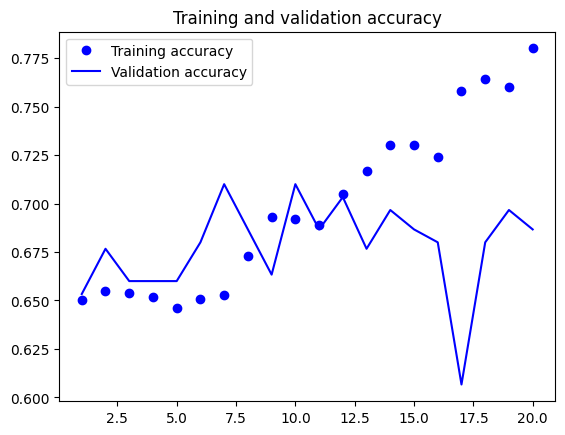

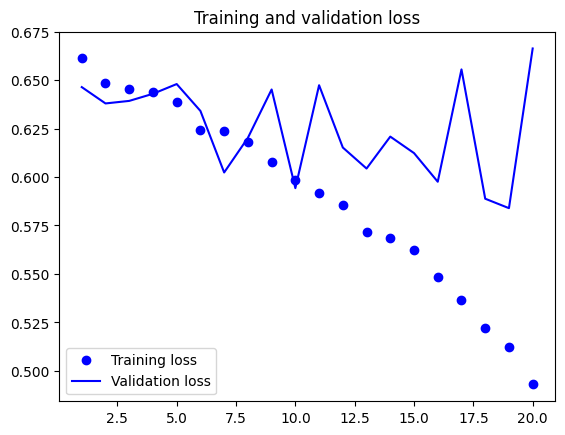

In [49]:
# Plotting Training and Validation Accuracy/Loss

acc_dropout = history_dropout.history['acc']
val_acc_dropout = history_dropout.history['val_acc']
loss_dropout = history_dropout.history['loss']
val_loss_dropout = history_dropout.history['val_loss']

epochs = range(1, len(acc_dropout) + 1)

plt.plot(epochs, acc_dropout, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_dropout, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_dropout, 'bo', label='Training loss')
plt.plot(epochs, val_loss_dropout, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Adding the dropout layer seems to help with the overfitting problem and does not negatively affect the accuracy of the model like the augmentation of the images.

Therefore, the operation was a success.

Nevertheless, I think we can still reach better performance with other models by applying transfer learning. This means that we use already trained models for image classification like VGG-16 and EfficientNet - we use their trained, convolutional base and add a new classifier on top for this specific problem.

#### 5.2 Transfer Learning with EfficientNet

In [55]:
# Load EfficientNet from keras without the classifier
from keras.applications import EfficientNetB0
effnet_base = EfficientNetB0(
    weights='imagenet',               # keeping the convulational base
    include_top=False,                # removing the classifier to later train our own
    input_shape=(150, 150, 3)
)

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 150, 150, 3)          0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, 150, 150, 3)          7         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 150, 150, 3)          0         ['normalization_1

In [51]:
# Adding own densely connected classifier on top of the EfficientNet-Base
effnet_model = models.Sequential()
effnet_model.add(effnet_base)
effnet_model.add(layers.Flatten())
effnet_model.add(layers.Dense(256, activation='relu'))
effnet_model.add(layers.Dense(1, activation='sigmoid'))

effnet_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 5, 5, 1280)        4049571   
 )                                                               
                                                                 
 flatten_7 (Flatten)         (None, 32000)             0         
                                                                 
 dense_14 (Dense)            (None, 256)               8192256   
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 12242084 (46.70 MB)
Trainable params: 12200061 (46.54 MB)
Non-trainable params: 42023 (164.16 KB)
_________________________________________________________________


In [52]:
# Freezing the convolutional layers before training
print('Number of trainable weights before freeze: ', len(effnet_model.trainable_weights))

effnet_base.trainable = False    # Freeze
print('Number of trainable weights after freeze: ', len(effnet_model.trainable_weights))

Number of trainable weights before freeze:  215
Number of trainable weights after freeze:  4


In [53]:
# Compiling and training the model
effnet_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

history_effnet = effnet_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15
)

Epoch 1/20
50/50 [==============================] - 16s 186ms/step - loss: 0.7486 - acc: 0.5720 - val_loss: 0.6854 - val_acc: 0.6633
Epoch 2/20
50/50 [==============================] - 6s 111ms/step - loss: 0.6983 - acc: 0.5960 - val_loss: 0.6965 - val_acc: 0.3367
Epoch 3/20
50/50 [==============================] - 6s 122ms/step - loss: 0.6904 - acc: 0.6070 - val_loss: 0.6683 - val_acc: 0.6367
Epoch 4/20
50/50 [==============================] - 6s 111ms/step - loss: 0.6803 - acc: 0.6260 - val_loss: 0.7041 - val_acc: 0.6633
Epoch 5/20
50/50 [==============================] - 7s 148ms/step - loss: 0.6996 - acc: 0.5860 - val_loss: 0.6544 - val_acc: 0.6500
Epoch 6/20
50/50 [==============================] - 6s 113ms/step - loss: 0.6839 - acc: 0.6280 - val_loss: 0.6702 - val_acc: 0.6400
Epoch 7/20
50/50 [==============================] - 7s 138ms/step - loss: 0.6981 - acc: 0.6220 - val_loss: 0.6515 - val_acc: 0.6533
Epoch 8/20
50/50 [==============================] - 5s 108ms/step - loss: 0

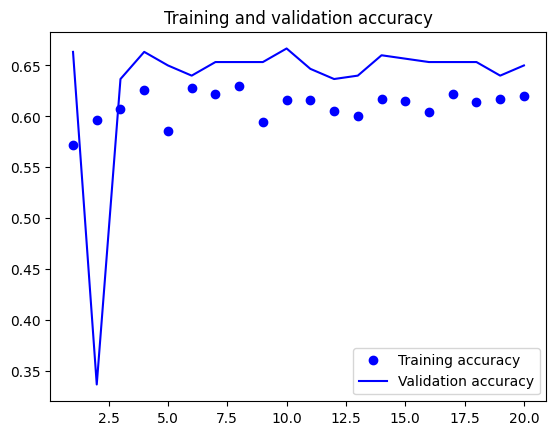

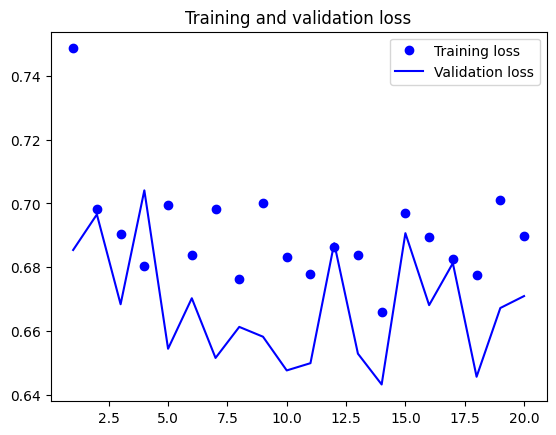

In [54]:
# Plotting Training and Validation Accuracy/Loss

acc_effnet = history_effnet.history['acc']
val_acc_effnet = history_effnet.history['val_acc']
loss_effnet = history_effnet.history['loss']
val_loss_effnet = history_effnet.history['val_loss']

epochs = range(1, len(acc_effnet) + 1)

plt.plot(epochs, acc_effnet, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_effnet, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_effnet, 'bo', label='Training loss')
plt.plot(epochs, val_loss_effnet, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The EfficientNet performs worse than my own model This could be due to its architecture with various augmentation layers for reshaping the images.

As already proven above, some augmentations (especially shifting, cropping etc.) can lead to misclassification due to shifting the logos out of "with logo" pictures.

This is why I will now set up a new model on basis of the vgg16 architecture. In Vgg16 there are no layers for data augmentation which should prove helpful for this particular classification problem.

#### 5.3 Transfer Learning with VGG16

In [92]:
# Loading VGG-16 base from keras
from keras.applications import VGG16

# Loading the model
vgg16_base = VGG16(
    weights='imagenet',             # keeping the convulational base
    include_top=False,              # removing the classifier to later train our own
    input_shape=(150, 150, 3)
)

vgg16_base.summary()

print('As mentioned above, the VGG16 architecture does not include augmentation layers.')

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [57]:
# Adding own densely connected classifier on top of the VGG16-Base
vgg16_model = models.Sequential()
vgg16_model.add(vgg16_base)
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(256, activation='relu'))
vgg16_model.add(layers.Dense(1, activation='sigmoid'))

vgg16_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_16 (Dense)            (None, 256)               2097408   
                                                                 
 dense_17 (Dense)            (None, 1)                 257       
                                                                 
Total params: 16812353 (64.13 MB)
Trainable params: 16812353 (64.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [58]:
# Freezing the convolutional layers before training
print('Number of trainable weights before freeze: ', len(vgg16_model.trainable_weights))

vgg16_base.trainable = False    # Freeze
print('Number of trainable weights after freeze: ', len(vgg16_model.trainable_weights))

Number of trainable weights before freeze:  30
Number of trainable weights after freeze:  4


In [59]:
# Compiling and training the model
vgg16_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['acc']
)

history_vgg16 = vgg16_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15
)

Epoch 1/20
50/50 [==============================] - 10s 122ms/step - loss: 0.6227 - acc: 0.6640 - val_loss: 0.5686 - val_acc: 0.7033
Epoch 2/20
50/50 [==============================] - 5s 109ms/step - loss: 0.5369 - acc: 0.7360 - val_loss: 0.5431 - val_acc: 0.7100
Epoch 3/20
50/50 [==============================] - 7s 141ms/step - loss: 0.4868 - acc: 0.7880 - val_loss: 0.5097 - val_acc: 0.7400
Epoch 4/20
50/50 [==============================] - 5s 106ms/step - loss: 0.4520 - acc: 0.7980 - val_loss: 0.4945 - val_acc: 0.7533
Epoch 5/20
50/50 [==============================] - 7s 136ms/step - loss: 0.4247 - acc: 0.8330 - val_loss: 0.4867 - val_acc: 0.7800
Epoch 6/20
50/50 [==============================] - 6s 110ms/step - loss: 0.3995 - acc: 0.8440 - val_loss: 0.4789 - val_acc: 0.7600
Epoch 7/20
50/50 [==============================] - 6s 114ms/step - loss: 0.3807 - acc: 0.8620 - val_loss: 0.4693 - val_acc: 0.7867
Epoch 8/20
50/50 [==============================] - 6s 112ms/step - loss: 0

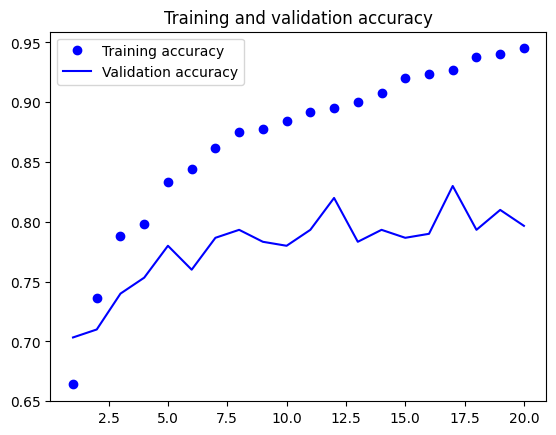

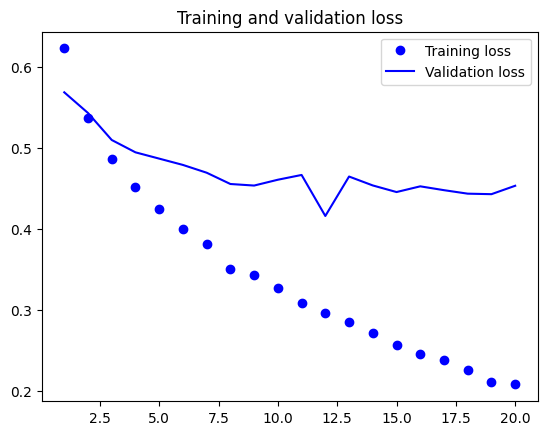

In [60]:
# Plotting VGG16 performance
acc_vgg16 = history_vgg16.history['acc']
val_acc_vgg16 = history_vgg16.history['val_acc']
loss_vgg16 = history_vgg16.history['loss']
val_loss_vgg16 = history_vgg16.history['val_loss']


# Plotting Training and Validation Accuracy/Loss
epochs = range(1, len(acc_vgg16) + 1)

plt.plot(epochs, acc_vgg16, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_vgg16, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_vgg16, 'bo', label='Training loss')
plt.plot(epochs, val_loss_vgg16, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Since the VGG 16 model performs very good on the data with a training accuracy of approx. 95%, I will now further tune this model instead of spending more time on finding another ConvNet model for transfer learning.

In the 'fine-tuning' step I will focus on tackling the overfitting problem we seem to have here. Againg the training accuracy increases with the epochs - however, the validation accuracy stalls at 70-80%.


### 6. Fine-tune the System

Since the VGG16 transfer-learning model performed the best, I will now fine-tune it by:

1. Adding a dropout layer to tackle the overfitting issue
2. Increasing the number of neurons in the dense layer
3. Unfreezing the top layer of the convolutianol base and training it together with the newly added classifier
4. Lowering the learning rate to prevent overfitting
5. Applying early_stop to prevent overfitting

This should result in overall better performance and a lower generalization error.

In [93]:
# Adding a dropout layer
# Adding own densely connected classifier on top of the VGG16-Base
tuned_vgg16_model = models.Sequential()
tuned_vgg16_model.add(vgg16_base)
tuned_vgg16_model.add(layers.Flatten())
tuned_vgg16_model.add(layers.Dropout(0.5))
tuned_vgg16_model.add(layers.Dense(512, activation='relu'))
tuned_vgg16_model.add(layers.Dense(1, activation='sigmoid'))

tuned_vgg16_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 8192)              0         
                                                                 
 dropout_10 (Dropout)        (None, 8192)              0         
                                                                 
 dense_28 (Dense)            (None, 512)               4194816   
                                                                 
 dense_29 (Dense)            (None, 1)                 513       
                                                                 
Total params: 18910017 (72.14 MB)
Trainable params: 18910017 (72.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [94]:
# Freezing the convolutional layers before training
print('Number of trainable weights before freeze: ', len(tuned_vgg16_model.trainable_weights))

vgg16_base.trainable = False    # Freeze
print('Number of trainable weights after freeze: ', len(tuned_vgg16_model.trainable_weights))

print('Since we already freezed the base for the first vgg16 model, we do not need to do it again.')

Number of trainable weights before freeze:  30
Number of trainable weights after freeze:  4
Since we already freezed the base for the first vgg16 model, we do not need to do it again.


In [95]:
# Training the model
from keras.callbacks import EarlyStopping

tuned_vgg16_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

early_stop = EarlyStopping(monitor='val_acc', patience=3)   # if the accuracy decreases for 3 times in a row, the training will be stopped

history_tuned_vgg16 = tuned_vgg16_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks=[early_stop]
)

Epoch 1/20
50/50 [==============================] - 8s 149ms/step - loss: 0.6862 - acc: 0.6050 - val_loss: 0.5885 - val_acc: 0.7067
Epoch 2/20
50/50 [==============================] - 6s 111ms/step - loss: 0.6231 - acc: 0.6600 - val_loss: 0.5508 - val_acc: 0.7167
Epoch 3/20
50/50 [==============================] - 7s 136ms/step - loss: 0.5975 - acc: 0.6910 - val_loss: 0.5421 - val_acc: 0.7433
Epoch 4/20
50/50 [==============================] - 6s 110ms/step - loss: 0.5676 - acc: 0.7050 - val_loss: 0.5261 - val_acc: 0.7800
Epoch 5/20
50/50 [==============================] - 6s 119ms/step - loss: 0.5352 - acc: 0.7370 - val_loss: 0.4939 - val_acc: 0.7667
Epoch 6/20
50/50 [==============================] - 6s 111ms/step - loss: 0.5187 - acc: 0.7360 - val_loss: 0.5017 - val_acc: 0.7833
Epoch 7/20
50/50 [==============================] - 6s 109ms/step - loss: 0.4835 - acc: 0.7730 - val_loss: 0.4939 - val_acc: 0.7567
Epoch 8/20
50/50 [==============================] - 7s 138ms/step - loss: 0.

In [96]:
# Unfreeze the last layer of the convolutional base ('block5')
vgg16_base.trainable = True

set_trainable = False
for layer in vgg16_base.layers:
  if layer.name == 'block5_conv1' :
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False


In [97]:
# Fine-tune the unfreezed convolutional layer together with the new classifier
tuned_vgg16_model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=1e-5),
    metrics=['acc']
)

history_tuned_vgg16 = tuned_vgg16_model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=15,
    callbacks=[early_stop]
)

Epoch 1/20
50/50 [==============================] - 8s 125ms/step - loss: 0.4358 - acc: 0.7990 - val_loss: 0.4095 - val_acc: 0.8167
Epoch 2/20
50/50 [==============================] - 6s 113ms/step - loss: 0.3663 - acc: 0.8430 - val_loss: 0.3917 - val_acc: 0.8167
Epoch 3/20
50/50 [==============================] - 6s 113ms/step - loss: 0.3175 - acc: 0.8760 - val_loss: 0.3922 - val_acc: 0.8300
Epoch 4/20
50/50 [==============================] - 6s 111ms/step - loss: 0.2823 - acc: 0.8850 - val_loss: 0.3947 - val_acc: 0.8233
Epoch 5/20
50/50 [==============================] - 7s 137ms/step - loss: 0.2312 - acc: 0.9060 - val_loss: 0.3813 - val_acc: 0.8300
Epoch 6/20
50/50 [==============================] - 7s 149ms/step - loss: 0.2028 - acc: 0.9240 - val_loss: 0.3772 - val_acc: 0.8333
Epoch 7/20
50/50 [==============================] - 6s 119ms/step - loss: 0.1657 - acc: 0.9480 - val_loss: 0.3737 - val_acc: 0.8367
Epoch 8/20
50/50 [==============================] - 6s 111ms/step - loss: 0.

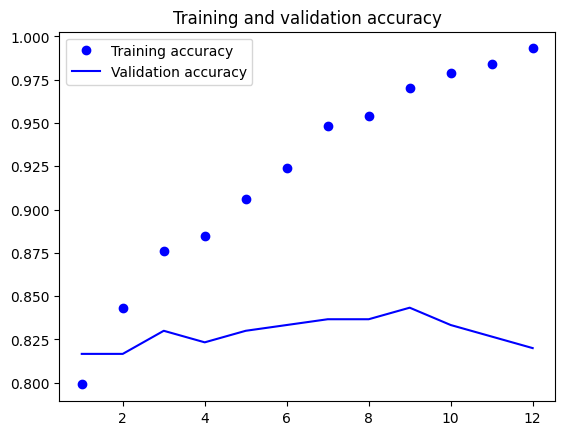

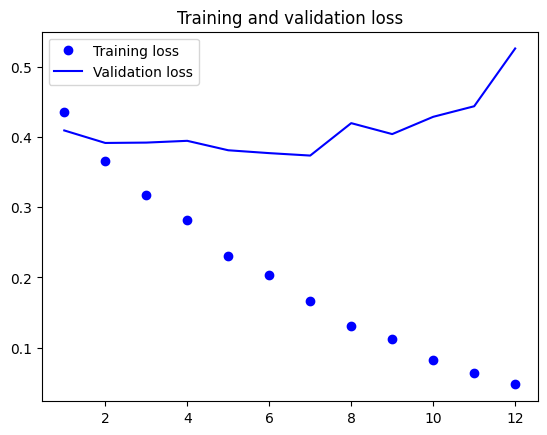

In [98]:
# Plotting VGG16 performance
acc_tuned_vgg16 = history_tuned_vgg16.history['acc']
val_acc_tuned_vgg16 = history_tuned_vgg16.history['val_acc']
loss_tuned_vgg16 = history_tuned_vgg16.history['loss']
val_loss_tuned_vgg16 = history_tuned_vgg16.history['val_loss']


# Plotting Training and Validation Accuracy/Loss
epochs = range(1, len(acc_tuned_vgg16) + 1)

plt.plot(epochs, acc_tuned_vgg16, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc_tuned_vgg16, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss_tuned_vgg16, 'bo', label='Training loss')
plt.plot(epochs, val_loss_tuned_vgg16, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

By fine-tuning the system we boosted the training accuracy to 99% (before 88%) and increased the validation accuracy to 82% (before 78%).

So overall the fine-tuning increased the performance of the model.

However, we still have an issue with overfitting, although we added a dropout layer to the network. This could be mainly due to the small size of the dataset at hand.

Since 82% is a pretty solid accuracy for a classifier trained on such a small dataset, I will now stop with fine-tuning and measure the performance of the model on the test data.

In [151]:
# Measuring the performance of the model on the test set to estimate the generalization error.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = tuned_vgg16_model.evaluate(test_generator, steps=15)
print('The accuracy on the test set is: ', test_acc)
print('The loss on the test set is: ', test_loss)

Found 341 images belonging to 2 classes.
15/15 [==============================] - 1s 81ms/step - loss: 0.6222 - acc: 0.8000
The accuracy on the test set is:  0.800000011920929
The loss on the test set is:  0.6222362518310547


18/18 [==============================] - 1s 80ms/step


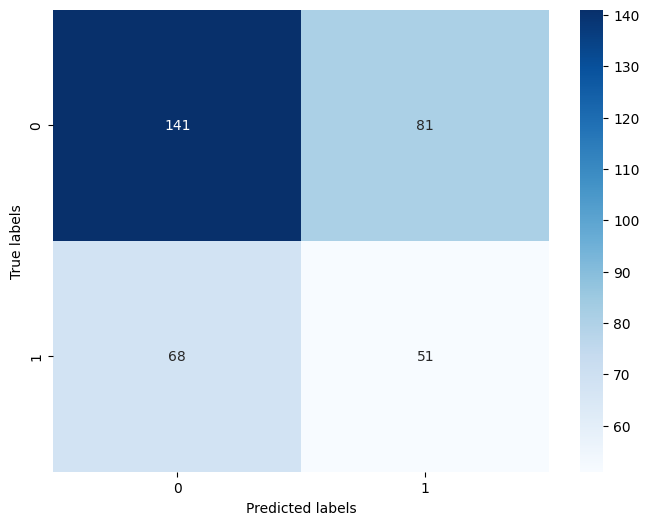

In [348]:
test_predictions = tuned_vgg16_model.predict(test_generator)

test_predictions_binary = (test_predictions > 0.5).astype(int)

from sklearn.metrics import confusion_matrix

test_true_labels = test_generator.classes
test_cm = confusion_matrix(test_true_labels, test_predictions_binary)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

The confusion matrix shows that the model is better in classifying the negative instances, meaining the images without a logo.

The model still has problems with classifying images with logos.

Again the reason for this could be that the dataset is too small and additionaly imbalanced. As shown in the beginning of the assignment there is an imbalance in the dataset - there are more images without logo (65%) than with logo (35%).

Accordingly, the model can better predict instances where a logo is missing since it had more training on such images.

The solution for this would be to balance the dataset by adding more images with logos to get to a ratio of 50/50.

But: As mentioned previously, there was no dataset with real-world images with/without logo that I could find in the internet besides the one I could not access. Therefore, this would be a task I would have done if I had more time.

For the assignment an accuracy of 80% is still good enough for the given dataset at hand.  

### 7. Present Your Solution
Please briefly summarize your results and reflect on your key learnings:

**What went well? What didn't go well?**

The early steps - loading and creating the directories, augmenting the data, splitting into training, validation and test set as well as setting up the architecture of the convnets - went very well considering that I am still a beginner.

The hard part was to fine-tune the vgg16 model. I had to read a lot documentation in order to get an idea how to increase the performance of the model while still keeping an eye on overfitting. This took me a while, especially because every time you adjust something, you need to train the model again and wait for colab to load.

With more experience, I think this would have taken less time and less effort.

Additionaly, I was not able to find another dataset with real-world logo images online. The only one I found (FlickrLogo), was not available unless you ask for it via email.

I tried that, but unfortunately got no answer..


**What are your system's limitations?**

For this task I had no problems with any system limitations. The training of the models took some time, but not too much.

I could have tried to train with more epochs but decided against because there was already a problem with overfitting.

**What would you try or change if you had more time for this machine-learning project?**

I would definetly add some image data on top. The dataset is really small. Augmentation helped a bit, but:
1. Even with three times as much data the dataset was still too small in my opinion.
2. Augmentation helps but is not optimal since the pictures are still the same and you just add some variation to it.

Besides adding more data, I could also test some of the other architectures for image classification (MobileNet, ResNet50, Inception etc.). Maybe there would have been a model where overfitting would not have been that much of an issue.

In [ ]:
BEST_ACCURACY =     80% # accuracy on the TEST set of the winning method (in %)
NB_OF_METHODS =     3 # Own model (2 different architectures), EfficientNet and VGG16
NB_OF_FIGURES =     6 # 2 pie charts, 1 bar chart, image examples, proof of augmentation, loss/accuracy charts and confusion matrix
DATA_ADDITION =     No # but augmentation was used to increase the size of the dataset

### 8. "Launch"
Please submit your **Jupyter Notebook (.ipynb)** and a **PDF version** of it on Canvas.

Both files should include *all cell outputs* after running the entire script.  You do not need to submit the ConvNet itself.

In [72]:
# Saving final model
tuned_vgg16_model.save('my_model_logo_classification_1.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Congrats. You made it!